In [2]:
library(sits)
library(sitsdata)
library(dplyr)
library(ggplot2)
library(ggrepel)
library(tidyverse)
library(plotly)
library(stars)
library(leaflet)

In [3]:
read_file <- function(file, ext) {
  data.tb <- NULL
  if (ext == "csv") {
    data.tb <- read.csv(file)
  }
  if (ext == "rds") {
    data.tb <- readRDS(file)
  }
  if (ext == "rda") {
    data.tb <- get(load(file))
  }
  return(data.tb)
}

In [4]:
point_to_shape_sp <- function (data.tb, class_label) {
  group_shape <- dplyr::select(data.tb,
    longitude, latitude,
    start_date, end_date,
    label #, cube
  )
  sp_data.tb.df <- as.data.frame(group_shape)
  sp_data.tb.df <- sp_data.tb.df %>% filter(label == class_label)
  points_SF <- as.data.frame(sp_data.tb.df)
  xy <- points_SF[, c(1, 2)]
  sp_data.df <- sp::SpatialPointsDataFrame(
    coords = xy,
    data = points_SF,
    proj4string = sp::CRS("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")
  )
  return(sp_data.df)
}

In [5]:
as_sample <- function(data.tb) {
    data.tb <- as.data.frame(data.tb)
#     data.tb <- dplyr::select(data.tb, -cube)
#     data.tb <- dplyr::mutate(data.tb, cube = coverage, .after = 5)
#     data.tb <- dplyr::select(data.tb, -coverage, -time_series)
#     data.tb <- dplyr::select(data.tb, -time_series)
    return(data.tb)
}

In [6]:
save_file <- function(data.tb, name) {
#     write.csv(data.tb, paste("./data/samples/csv", name, ".csv", sep=""), row.names = FALSE)
    save(data.tb, file = paste("./data/ts_coupled_samples/", name, ".rda", sep=""))
}

# BDC Data Cube

In [11]:
Sys.setenv(BDC_ACCESS_KEY = "a6gB61oddyHxMAZ08y098ynEq0s1hQ3siDZao245CV")

lc8_cerrado_cube <- sits_cube(
        source     = "BDC",
        name       = "amazonia",
        collection = "LC8_30_16D_STK-1",
        tiles      = c("040048", "040049", "040050", "040053",
                       "041048", "041049", "041050", "041051",
                       "041052", "041053", "041054", "042047",
                       "042048", "042049", "042050", "042051",
                       "042052", "042053", "043045", "043046",
                       "043047", "043048", "043049", "043050",
                       "043051", "043052", "043053", "043054",
                       "044044", "044045", "044046", "044047",
                       "044048", "044049", "044050", "044051",
                       "044052", "044053", "045043", "045044",
                       "045045", "045046", "045047", "045048",
                       "045049", "045050", "045051", "045052",
                       "046043", "046044", "046045"),
        start_date = "2017-09-01",
        end_date   = "2018-08-31"
)
options(repr.plot.width = 5, repr.plot.height = 5)
plot(lc8_cerrado_cube, band = "NDVI", time = 2)

sits_timeline(lc8_cerrado_cube)

ERROR: Error: The bands contained in this product are not mapped in the SITS package, if you want to include them please provide it in configuration file.


# Study Case: SINOP Mato Grosso - MT, Brazil

In [44]:
file_name <- "./data/samples/csv/samples_sinop_crop.csv"
ext <- "csv"

In [45]:
input_data.tb <- read_file(file_name, ext)
input_data.tb <- as_sample(input_data.tb)
head(input_data.tb, 5)

id longitude latitude  start_date end_date   label  
1 1  -55.65931 -11.76267 2013-09-14 2014-08-29 Pasture
2 2  -55.64833 -11.76385 2013-09-14 2014-08-29 Pasture
3 3  -55.66738 -11.78032 2013-09-14 2014-08-29 Forest 
4 4  -55.64747 -11.75276 2013-09-14 2014-08-29 Pasture
5 5  -55.65742 -11.78788 2013-09-14 2014-08-29 Forest

In [46]:
group <- dplyr::group_by(input_data.tb, label)
agregation <- dplyr::summarise(group, n = n(), .groups = "drop_last")
mutation <- dplyr::mutate(agregation, percent = n/sum(n))
mutation <- data.frame(mutation)
mutation

label    n percent  
1 Cerrado  3 0.1666667
2 Forest   3 0.1666667
3 Pasture  4 0.2222222
4 Soy_Corn 8 0.4444444

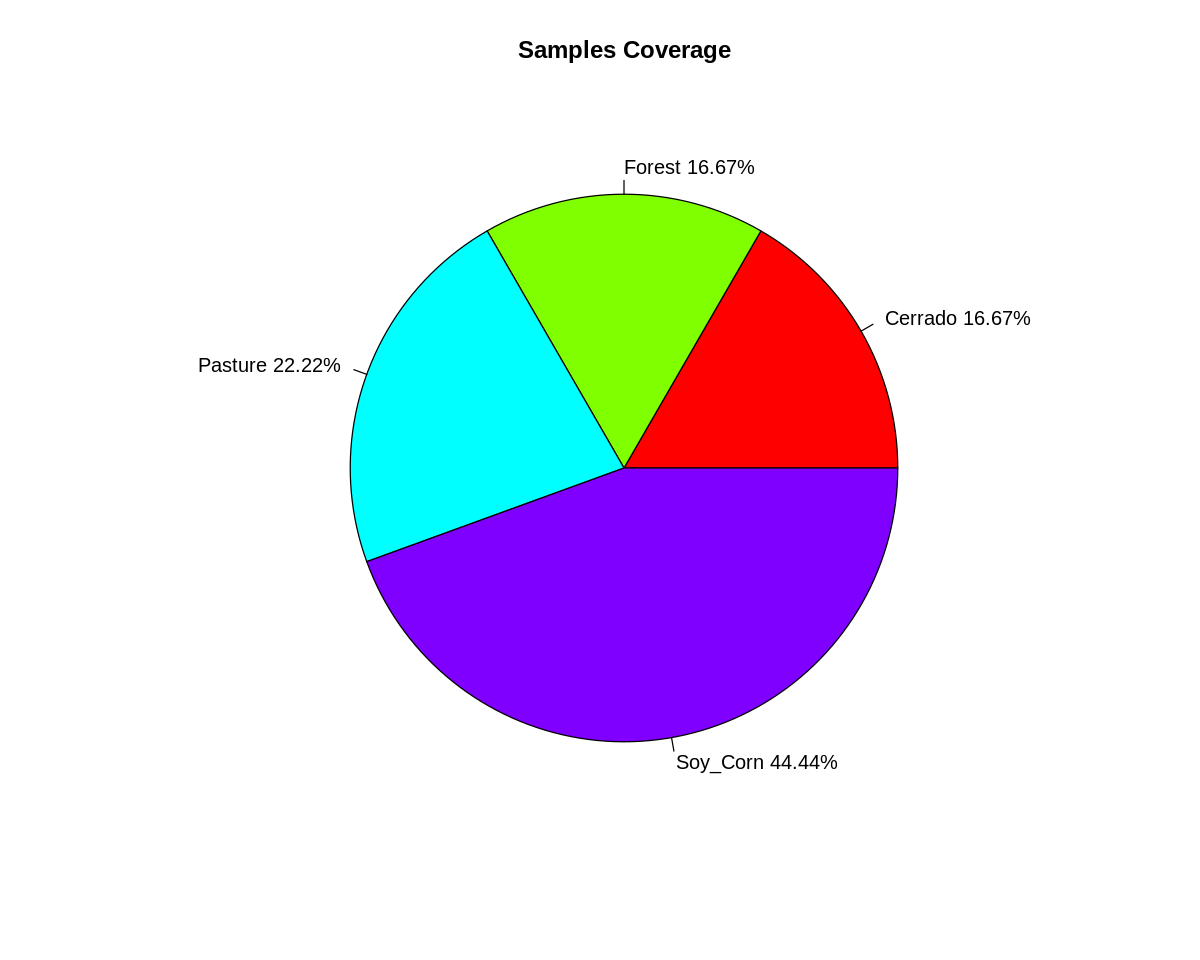

In [47]:
# Configure plot size 
options(repr.plot.width = 10, repr.plot.height = 8)
pie(
    mutation$percent,
    paste(mutation$label, " ", round(mutation$percent*100, 2), "%", sep=""),
    col=rainbow(length(mutation$label)), 
    main="Samples Coverage"
)

In [48]:
shape <- point_to_shape_sp(
    data.tb = input_data.tb,
    class_label = "Soy_Corn"
)
leaflet(shape, options = leafletOptions(minZoom = 0, maxZoom = 100)) %>%
        addTiles() %>%
            addMarkers(
                ~longitude, ~latitude,
                popup = ~as.character(
                    paste("Class '", label, "' |",
                        format(
                            as.Date(start_date),
                            format = "Start %Y-%m-%d"
                        ),
                        format(
                            as.Date(end_date),
                            format = "End %Y-%m-%d"
                        )
                    )))

HTML widgets cannot be represented in plain text (need html)

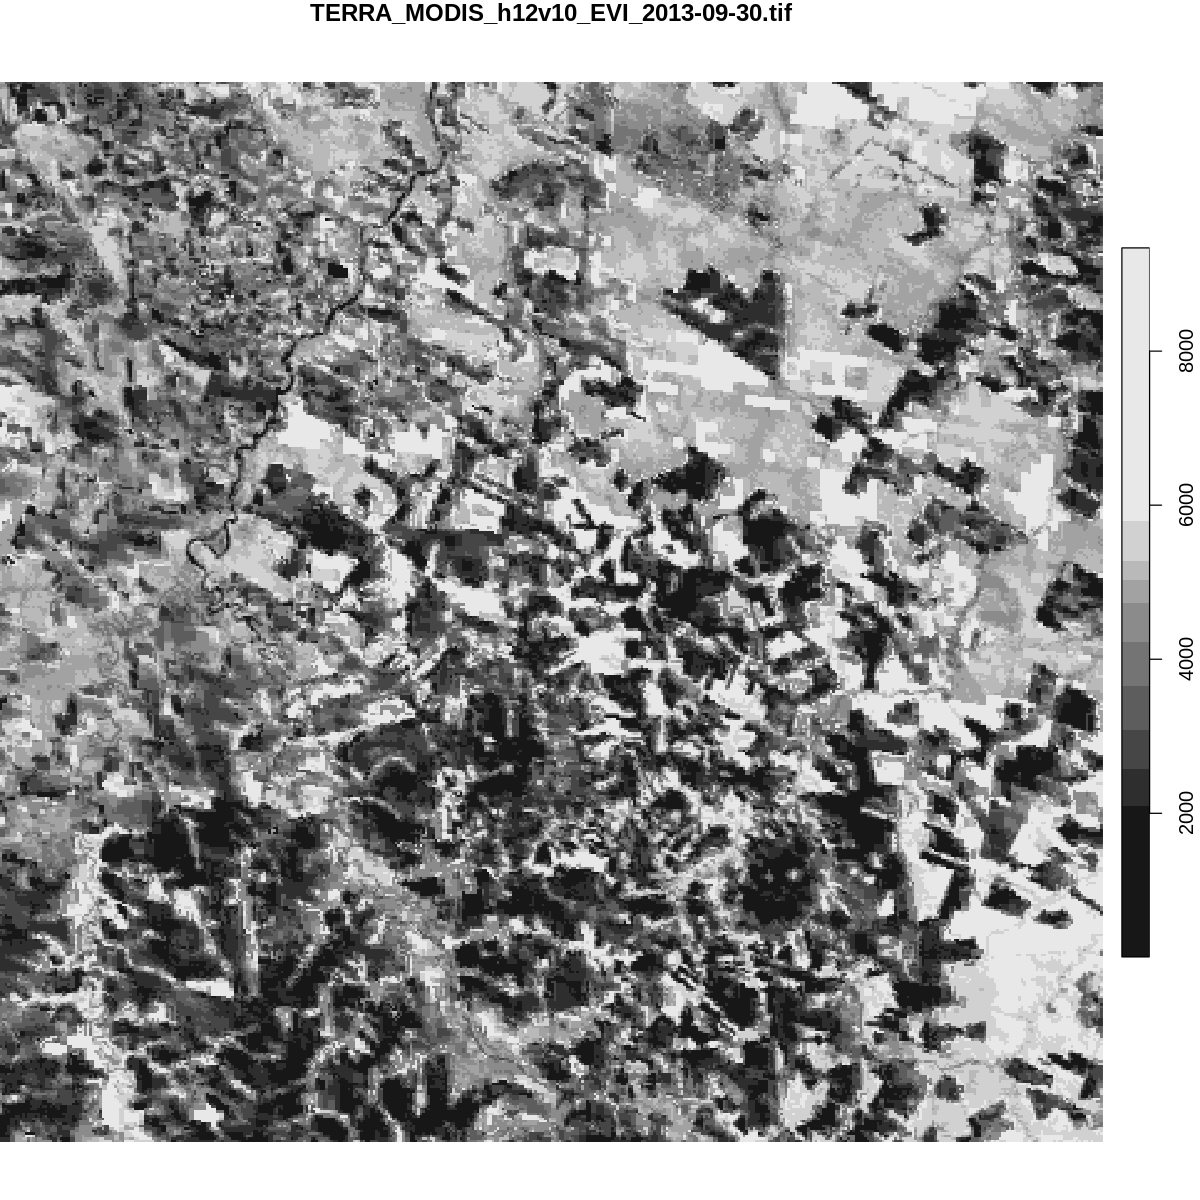

In [49]:
data_dir <- system.file("extdata/sinop", package = "sitsdata")
raster_cube <- sits_cube(
        source = "LOCAL",
        name = "sinop-2014",
        satellite = "TERRA",
        sensor = "MODIS",
        data_dir = data_dir
)
options(repr.plot.width = 10, repr.plot.height = 10)
plot(raster_cube, band = "EVI", time = 2)

In [50]:
points <- sits_get_data(raster_cube, file = file_name)
head(points, 1)

All points have been retrieved



longitude latitude  start_date end_date   label   cube      
1 -55.65931 -11.76267 2013-09-14 2014-08-29 Pasture sinop-2014
  time_series                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
1 15962.0000, 15978.0000, 15994.0000, 16010.0000, 16026.0000, 16042.0000, 16058.0000, 16071.0000, 16087.0000, 16103.0000, 16119.0000, 16135.0000, 16151.0000, 16167.0000, 16183.0000, 16199.0000, 16215.0000, 16231.0000, 16247.0000, 16263.0000, 16279.0000, 16295.0000, 16311.0000, 0.2106, 0.3169, 0.2674, 0.3430, 0.3897, 0.4803, 0.5254, 0.5254, 0.4680, 0.4708, 0.1790, 0.3151, 0.4756, 0.4006, 0.4509, 0.4284, 0.3551, 0.3730, 0.3146, 0.2480, 0.1967, 0.1883, 0.2211, 0.3386, 0.4327, 0.4608, 0.5664, 0.4799, 0.5867, 0.6543, 0.6543, 0.6912, 0.6439, 0.1721, 0.7537, 0.7299, 0.6144, 0.6653, 0.6510, 0.5940, 0.6135, 0.5229, 0.4271, 0.3451, 0.3182, 0.3272

In [51]:
head(tibble(points$time_series[[1]]), 3)

Index      EVI    NDVI  
1 2013-09-14 0.2106 0.3386
2 2013-09-30 0.3169 0.4327
3 2013-10-16 0.2674 0.4608

In [52]:
points[3,]

longitude latitude  start_date end_date   label  cube      
1 -55.66738 -11.78032 2013-09-14 2014-08-29 Forest sinop-2014
  time_series                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
1 15962.0000, 15978.0000, 15994.0000, 16010.0000, 16026.0000, 16042.0000, 16058.0000, 16071.0000, 16087.0000, 16103.0000, 16119.0000, 16135.0000, 16151.0000, 16167.0000, 16183.0000, 16199.0000, 16215.0000, 16231.0000, 16247.0000, 16263.0000, 16279.0000, 16295.0000, 16311.0000, 0.5536, 0.4968, 0.5135, 0.4770, 0.5706, 0.5779, 0.6282, 0.6282, 0.4847, 0.4121, 0.1624, 0.4525, 0.3854, 0.4338, 0.4575, 0.4302, 0.4053, 0.4036, 0.4098, 0.3976, 0.4292, 0.4671, 0.5526, 0.8204, 0.8025, 0.8601, 0.8928, 0.7993, 0.8830, 0.8442, 0.8442, 0.8314, 0.7653, 0.1876, 0.8417, 0.8159, 0.8936, 0.8430, 0.8233, 0.8315, 0.8170, 0.8280, 0.8152, 0.8042, 0.8297, 0.8163

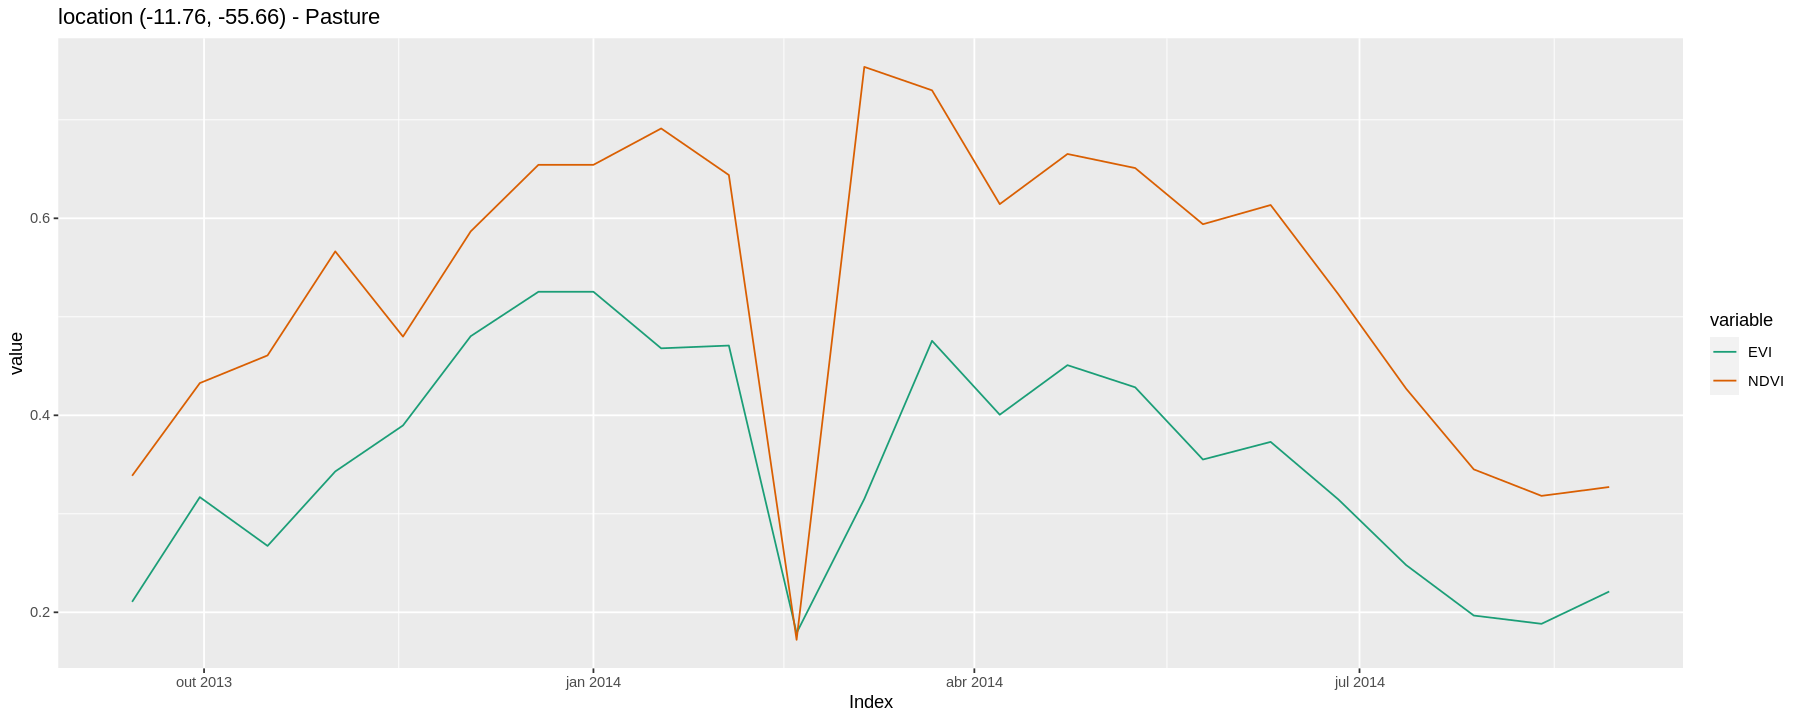

In [53]:
options(repr.plot.width = 15, repr.plot.height = 6)
filtered <- dplyr::filter(points, label == "Soy_Corn")
plot(points[1,])

In [54]:
save_file(points, "samples_sinop_response_sits")

In [55]:
wtss_inpe <- "https://brazildatacube.dpi.inpe.br/wtss/"
Rwtss::list_coverages(wtss_inpe)

[1] "MOD13Q1-6"               "MYD13Q1-6"              
 [3] "S2_10_16D_STK-1"         "S2-SEN2COR_10_16D_STK-1"
 [5] "S2_10-1"                 "CB4MUX_20-1"            
 [7] "CB4MUX_20_1M_STK-1"      "LC8_30-1"               
 [9] "LC8_30_16D_STK-1"        "CB4_20_1M_STK-1"        
[11] "LC8_30_6M_MEDSTK-1"      "CB4_64_16D_STK-1"       
[13] "CB4_64-1"                "LANDSAT-MOZ_30_1M_STK-1"

In [56]:
coverage <- "MOD13Q1-6"
desc <- Rwtss::describe_coverage(wtss_inpe, name = coverage)
desc$bands

---------------------------------------------------------------------
WTSS server URL = https://brazildatacube.dpi.inpe.br/wtss
Cube (coverage) = MOD13Q1-6

|satellite|sensor|bands                                                                                                                                                                                                                                                                                                                             |
|:--------|:-----|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|TERRA    |MODIS |view_zenith_angle        , sun_zenith_angle         , pixel_reliability        , relative_azimuth_angle   , blue_reflectance         , red_re

[[1]]
 [1] "view_zenith_angle"         "sun_zenith_angle"         
 [3] "pixel_reliability"         "relative_azimuth_angle"   
 [5] "blue_reflectance"          "red_reflectance"          
 [7] "NIR_reflectance"           "MIR_reflectance"          
 [9] "NDVI"                      "EVI"                      
[11] "VI_Quality"                "composite_day_of_the_year"

In [57]:
sample <- data.frame(head(input_data.tb, 1))
start <- sample$start_date
end <- sample$end_date
lat <- sample$latitude
long <- sample$longitude
bands <- c('NDVI', 'EVI', 'NIR_reflectance')

In [58]:
response = Rwtss::time_series(
    wtss_inpe, 
    name = coverage, 
    attributes = bands, 
    longitude = long,
    latitude  = lat,
    start_date = start, 
    end_date = end,
    token = "a6gB61oddyHxMAZ08y098ynEq0s1hQ3siDZao245CV"
)
cube <- response$cube
ts <- data.frame(response$time_series)
head(ts, 3)

Index      EVI    NDVI   NIR_reflectance
1 2013-09-14 0.2201 0.3532 0.3063         
2 2013-09-30 0.2693 0.4216 0.3370         
3 2013-10-16 0.2732 0.4831 0.2680

In [59]:
sample

id longitude latitude  start_date end_date   label  
1 1  -55.65931 -11.76267 2013-09-14 2014-08-29 Pasture

In [60]:
response <- dplyr::select(response, -label)
response <- dplyr::mutate(response, label = sample$label, .after = 4)
response

longitude latitude  start_date end_date   label   cube     
1 -55.65931 -11.76267 2013-09-14 2014-08-29 Pasture MOD13Q1-6
  time_series                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1 15962.0000, 15978.0000, 15994.0000, 16010.0000, 16026.0000, 16042.0000, 16058.0000, 16071.0000, 16087.0000, 16103.0000, 16119.0000, 16135.0000, 16151.0000, 16167.0000, 16183.0000, 16199.0000, 16215.0000, 16231.0000, 16247.0000, 16263.0000, 16279.0000, 16295.0000, 16311.0000, 0.2201, 0.2693, 0.2732, 0.3043, 0.3717, 0.4933, 0.5487, 0.5487, 0.4909, 0.4983, 0.1777, 0.3125, 0.4216, 0.4547, 0.4689, 0.4521, 0.3707, 0.3862, 0.3270, 0.2519, 0.2131, 0.1838, 0.2002, 0.3532, 0.4216, 0.4831, 0.5480, 0.4112, 0.6175, 0.6641, 0.6641, 0.6982, 0.6705, 0.1667, 0.2757, 0.4343, 0.6587, 0.6738, 0.6622, 0.5940, 0.6099, 0.5259, 0.4098, 0.3575, 0.3153, 0.3261, 0.3063, 0.3370, 0.2680, 0.2620, 0.4712, 0.3798, 0.4727, 0.4727, 0.3681, 0.3534, 0.4338, 0.5070, 0.4552, 0.3529, 0.3664, 0.3485, 0.3039, 0.3108, 0.2981, 0.3048, 0.2707, 0.2918, 0.2903

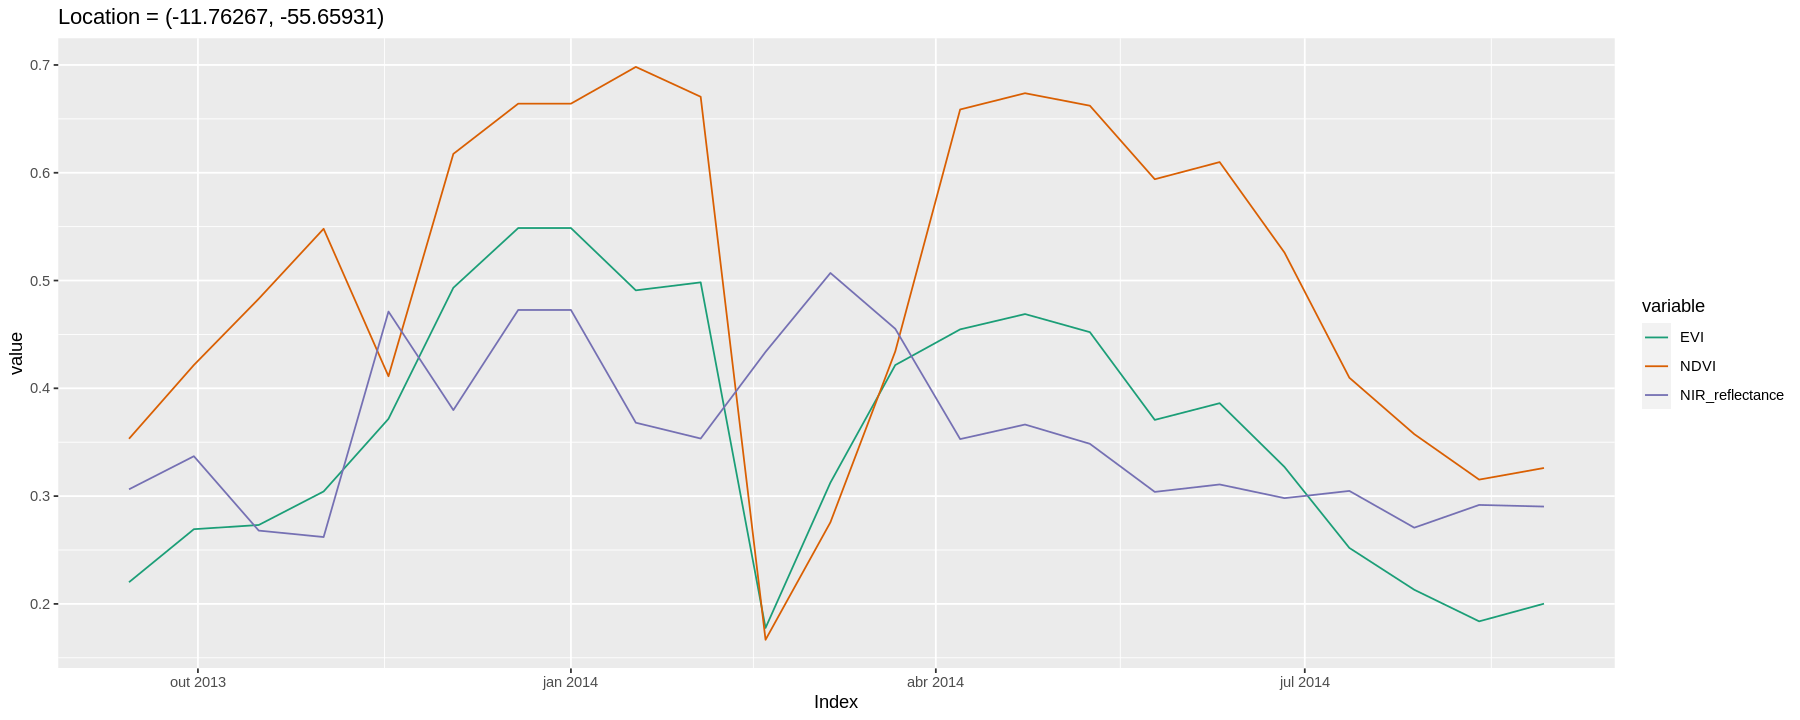

In [61]:
# Configure plot size 
options(repr.plot.width = 15, repr.plot.height = 6)
plot(response)

# Study Case: AMAZONAS Rondônia - RO, Brazil

In [7]:
file_name <- "./data/samples/csv/samples_amazonia_sentinel2.csv"
input_data.tb <- read_file(file_name, "csv")
head(input_data.tb, 3)

id longitude latitude  start_date end_date   label        
1 1  -64.69448 -9.986312 2018-07-12 2019-07-28 Deforestation
2 2  -64.62979 -9.996668 2018-07-12 2019-07-28 Deforestation
3 3  -64.52163 -9.979772 2018-07-12 2019-07-28 Deforestation

In [8]:
group <- dplyr::group_by(input_data.tb, label)
agregation <- dplyr::summarise(group, n = n(), .groups = "drop_last")
mutation <- dplyr::mutate(agregation, percent = n/sum(n))
mutation <- data.frame(mutation)
mutation

label         n   percent  
1 Deforestation 157 0.1306156
2 Forest        414 0.3444260
3 NatNonForest  171 0.1422629
4 Pasture       460 0.3826955

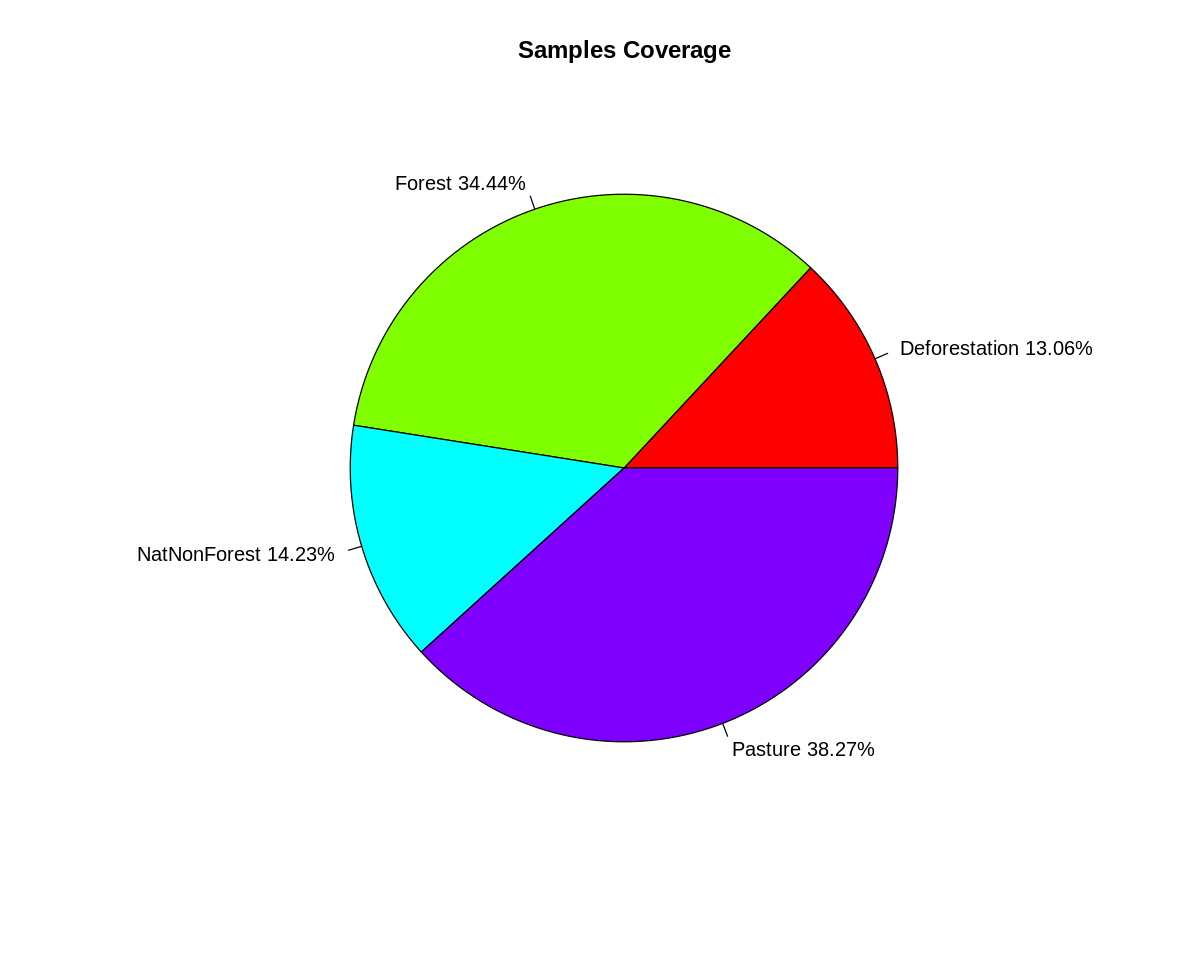

In [9]:
# Configure plot size 
options(repr.plot.width = 10, repr.plot.height = 8)
pie(
    mutation$percent,
    paste(mutation$label, " ", round(mutation$percent*100, 2), "%", sep=""),
    col=rainbow(length(mutation$label)), 
    main="Samples Coverage"
)

In [10]:
shape <- point_to_shape_sp(
    data.tb = input_data.tb,
    class_label = "Deforestation"
)
leaflet(shape, options = leafletOptions(minZoom = 0, maxZoom = 100)) %>%
        addTiles() %>%
            addMarkers(
                ~longitude, ~latitude,
                popup = ~as.character(
                    paste("Class '", label, "' |",
                        format(
                            as.Date(start_date),
                            format = "Start %Y-%m-%d"
                        ),
                        format(
                            as.Date(end_date),
                            format = "End %Y-%m-%d"
                        )
                    )))

HTML widgets cannot be represented in plain text (need html)

In [20]:
# Executar os comandos em testes_python.ipynb
# Renomear os arquivos de band4 e band8 para B04 e B08
# ou atualizar o arquivo config.yml em R/library/sits
data_dir <- "./data/raster/Sentinel/077095"
sentinel_cube <- sits_cube(
    source     = "LOCAL",
    name       = "sentinel-077095",
    satellite  = "SENTINEL-2",
    sensor     = "MSI",
    resolution = "10m",
    data_dir   = data_dir,
    parse_info = c("X1", "X2", "X3", "X4", "X5", "tile", "date", "X6", "band")
)

In [30]:
# %time%
points <- sits_get_data(sentinel_cube, file = file_name)
head(points, 1)

All points have been retrieved



longitude latitude  start_date end_date   label         cube           
1 -64.69448 -9.986312 2018-07-12 2019-07-28 Deforestation sentinel-077095
  time_series                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1 17724.0000, 17740.0000, 17756.0000, 17772.0000, 17788.0000, 17804.0000, 17820.0000, 17836.0000, 17852.0000, 17868.0000, 17884.0000, 17897.0000, 17913.0000, 17929.0000, 17945.0000, 17961.0000, 17977.0000, 17993.0000, 18009.0000, 18025.0000, 18041.0000, 18057.0000, 18073.0000, 18089.0000, 18105.0000, 0.0248, 0.0248, 0.0246, 0.0755, 0.0800, 0.0655, 0.0758, 0.0959, 0.4346, 0.0650, 0.0682, 0.4307, 0.0871, 0.0771, 0.4840, 0.0563, 0.0727, 0.0742, 0.1910, 0.0472, 0.3008, 0.0353, 0.0316, 0.0339, 0.0443, 0.2646, 0.2466, 0.2512, 0.2375, 0.2341, 0.2266, 0.1345, 0.2670, 0.4693, 0.1865, 0.1330, 0.5391, 0.2121, 0.2723, 0.5525, 0.3076, 0.2699, 0.2342, 0.3495, 0.2927, 0.4704, 0.3264, 0.3604, 0.3491, 0.3039, 0.5138, 0.4855, 0.5200, 0.3399, 0.3506, 0.4005, 0.1706, 0.4271, 0.3059, 0.3524, 0.1932, 0.5605, 0.2947, 0.4333, 0.3687, 0.5271, 0.4340, 0.3570, 0.4418, 0.5068, 0.4598, 0.6014, 0.6695, 0.6498, 0.5481, 0.8414, 0.8326, 0.8419, 0.5491, 0.5449, 0.6199, 0.3437, 0.5773, 0.1046, 0.5973, 0.4118, 0.0933, 0.4751, 0.6047, 0.1392, 0.7165, 0.6259, 0.5580, 0.3495, 0.7512, 0.2574, 0.8181, 0.8509, 0.8406, 0.7710

In [31]:
head(tibble(points$time_series[[1]]), 3)

Index      B04    B08    EVI    NDVI  
1 2018-07-12 0.0248 0.2646 0.5138 0.8414
2 2018-07-28 0.0248 0.2466 0.4855 0.8326
3 2018-08-13 0.0246 0.2512 0.5200 0.8419

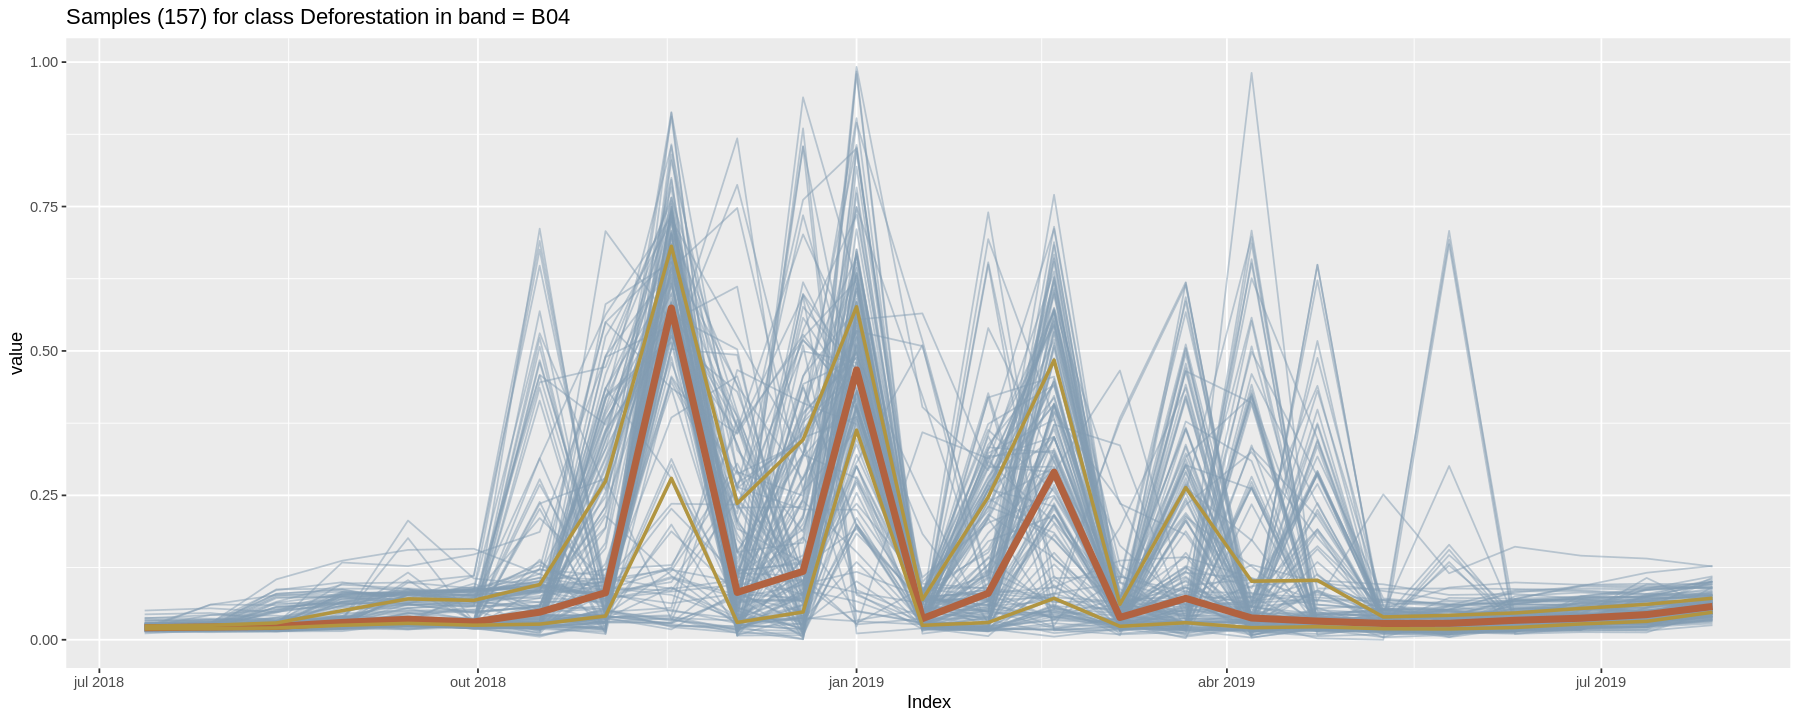

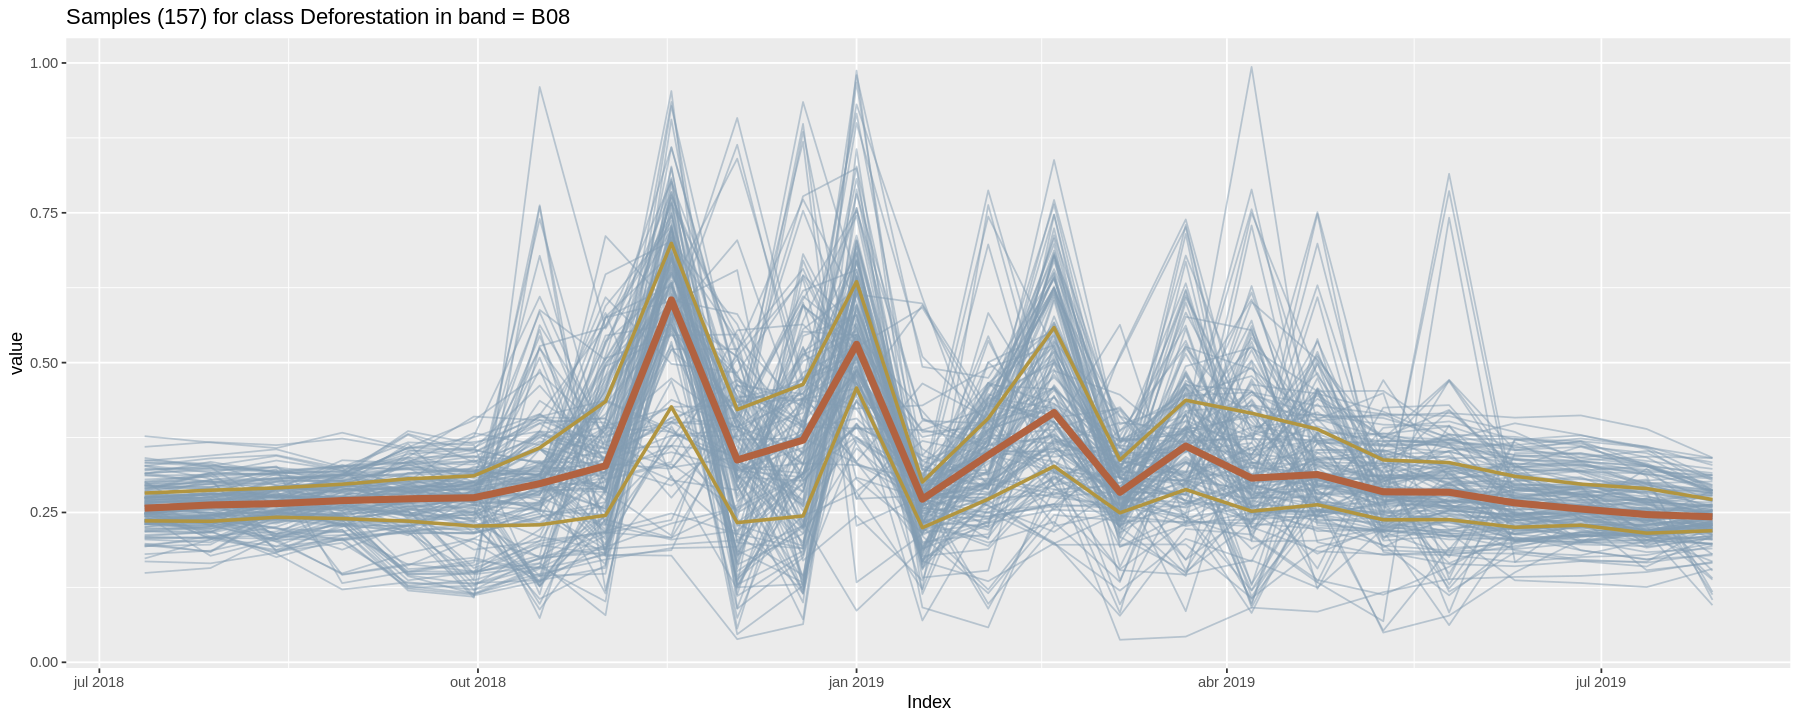

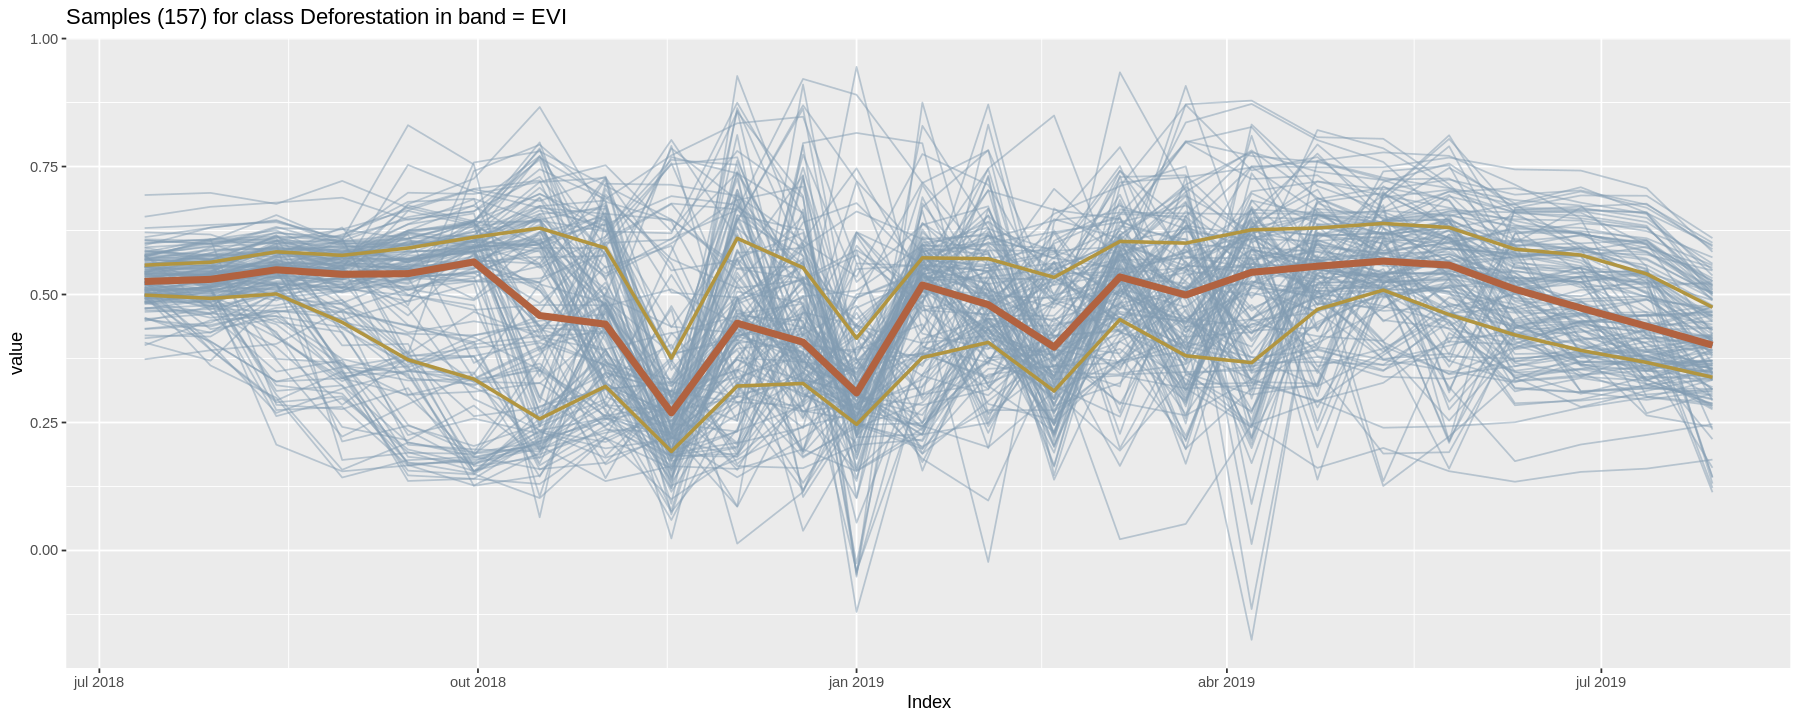

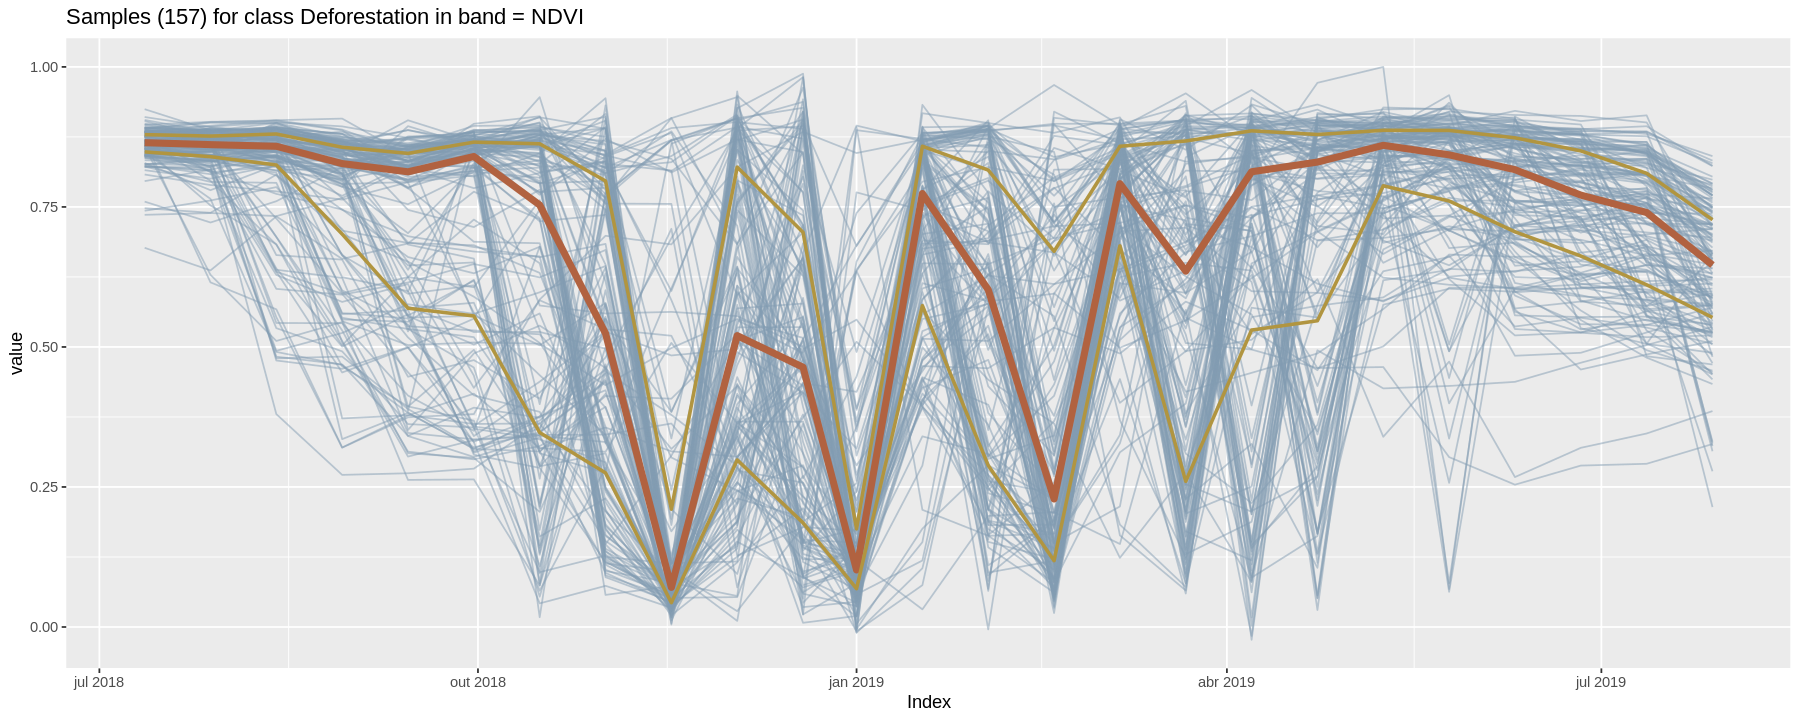

In [35]:
options(repr.plot.width = 15, repr.plot.height = 6)
filtered <- dplyr::filter(points, label == "Deforestation")
plot(filtered)

In [36]:
save_file(points, "samples_amazonia_sentinel2_b0408")